In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from transformers import create_optimizer

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
df_train = pd.read_csv('../data/train_cleaned.zip', compression='zip')
df_train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...,"['explanation', 'why', 'the', 'edits', 'made',...","['explanation', 'edits', 'made', 'username', '...","['explan', 'edit', 'made', 'usernam', 'hardcor...","[('explanation', 'NN'), ('edits', 'NNS'), ('ma...","['explanation', 'edits', 'made', 'username', '...","['explanation', 'edits', 'make', 'username', '...","[('explanation', 'edits'), ('edits', 'made'), ..."


In [4]:
df_test = pd.read_csv('../data/test_cleaned.zip', compression='zip')
df_test.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,thank you for understanding i think very highl...,"['thank', 'you', 'for', 'understanding', 'i', ...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highli', 'wo...","[('thank', 'NN'), ('understanding', 'VBG'), ('...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highly', 'wo...","[('thank', 'understanding'), ('understanding',..."


In [5]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: str(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: str(x))

# Multi-label classification task
  toxic, severe_toxic, obscene, threat, insult, identity_hate

In [21]:
#Input Layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

#Preprocessing Layer
preprocessing_layer = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_en_uncased_preprocess/2", name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)

#Encoder Layer
encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1", trainable=False, name='BERT_encoder')
outputs = encoder(encoder_inputs)

#Classification Layers
net = outputs['pooled_output']
net = tf.keras.layers.Dense(768, activation='relu', name='pre_classifier')(net)
#net = tf.keras.layers.Dropout(0.5)(net)
net = tf.keras.layers.Dense(6, activation='sigmoid', name='classifier')(net)

model = tf.keras.Model(inputs=[text_input], outputs=[net])

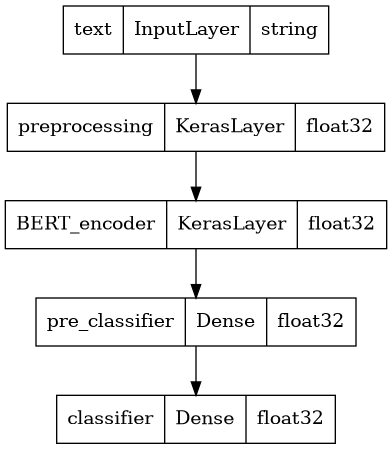

In [22]:
tf.keras.utils.plot_model(model, show_dtype=True)

In [23]:
df_sample = df_train.sample(frac=0.15, replace=False, random_state=42)
X = df_sample.clean_text
y = df_sample[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((19148,), (4788,))

In [24]:
X_test = df_test.clean_text
y_test = df_test[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
X_test.shape

(63978,)

In [28]:
batch_size = 32
epochs  = 2
batches_per_epoch = len(X_train) // batch_size
total_train_steps = int(batches_per_epoch * epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=['acc']
              #metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(),  tf.keras.metrics.Recall()]
             )

In [29]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                       epochs=epochs)

Epoch 1/2
599/599 [==============================] - 241s 399ms/step - loss: 0.0939 - acc: 0.9362 - val_loss: 0.0885 - val_acc: 0.9079
Epoch 2/2
599/599 [==============================] - 237s 395ms/step - loss: 0.0821 - acc: 0.9491 - val_loss: 0.0840 - val_acc: 0.9465


In [30]:
history.history

{'loss': [0.09394221007823944, 0.0821172371506691],
 'acc': [0.9362335205078125, 0.9491330981254578],
 'val_loss': [0.08848688751459122, 0.08397122472524643],
 'val_acc': [0.9078947305679321, 0.9465330243110657]}

In [31]:
predictions = model.predict(X_test)
y_pred = np.round(predictions)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.35      0.48      6090
           1       0.00      0.00      0.00       367
           2       0.90      0.23      0.36      3691
           3       0.00      0.00      0.00       211
           4       0.87      0.18      0.30      3427
           5       0.00      0.00      0.00       712

   micro avg       0.79      0.25      0.38     14498
   macro avg       0.42      0.13      0.19     14498
weighted avg       0.74      0.25      0.36     14498
 samples avg       0.03      0.02      0.02     14498



---

# transformers library (tf) ----- Test!!!!!

In [7]:
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

In [8]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [9]:
tokenizer(df_train.clean_text[0])

{'input_ids': [101, 7526, 2339, 1996, 10086, 2015, 2081, 2104, 2026, 5310, 18442, 13076, 12392, 2050, 5470, 2020, 16407, 2027, 2020, 2025, 3158, 9305, 22556, 2074, 8503, 2006, 2070, 3806, 2044, 1045, 5444, 2012, 2047, 2259, 14421, 6904, 2278, 1998, 3531, 2079, 2025, 6366, 1996, 23561, 2013, 1996, 2831, 3931, 2144, 1045, 2572, 3394, 2085, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=6)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [11]:
X = df_train.clean_text
y = df_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

#tokenize the text
X_train_enc = tokenizer(list(X_train), truncation=True, padding='max_length', max_length=200)
X_val_enc = tokenizer(list(X_val), truncation=True, padding='max_length', max_length=200)

In [12]:
print(f'Text: { X_train[:1] }')
print(f'Input ids: { X_train_enc["input_ids"][0] } ')
print(f'Input ids: { X_train_enc["attention_mask"][0] } ')

Text: 140030    grandma terri should burn in trash  grandma te...
Name: clean_text, dtype: object
Input ids: [101, 13055, 26568, 2323, 6402, 1999, 11669, 13055, 26568, 2003, 11669, 1045, 5223, 13055, 26568, 14352, 2014, 2000, 3109, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
Input ids: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train_enc), y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(X_val_enc), y_val.values))
train_dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(200,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(200,), dtype=tf.int32, name=None)}, TensorSpec(shape=(6,), dtype=tf.int64, name=None))>

In [35]:
from transformers import create_optimizer

batch_size = 16
epochs  = 3
batches_per_epoch = len(X_train) // batch_size
total_train_steps = int(batches_per_epoch * epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

#Setting distilbert layer non-trainable
layer = model.get_layer('distilbert')
layer.trainable = False

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics='acc')

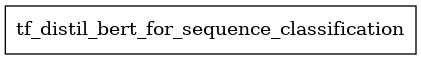

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [37]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,958,086
Trainable params: 595,206
Non-trainable params: 66,362,880
_________________________________________________________________


In [38]:
history = model.fit(train_dataset.batch(batch_size),
                       validation_data=val_dataset,
                       epochs=epochs)

Epoch 1/3
 843/7979 [==>...........................] - ETA: 25:16 - loss: 0.3125 - acc: 0.5449

KeyboardInterrupt: 